In [2]:
mutable struct Firm
    Q::AbstractMatrix  # inidices = price * k + 1 (to be 1-based, ints)
    prices::Array  # price history (save all for later calculations/plotting)
end

In [3]:
#= 
linear demand
provides collusive price 0.5, per-firm profit 0.125
=#
function D_i(p_i, p_j)
    if p_i < p_j
        1 - p_i
    elseif p_i == p_j
        0.5 * (1 - p_i)
    else
        0
    end
end


# profit
π_i(p_i, p_j) = p_i * D_i(p_i, p_j)

π_i (generic function with 1 method)

In [13]:
function duopoly(T::Int; k = 6::Int, α = 0.3, δ = 0.95)
    #= 
    T: periods
    k: price_intervals
    α: step_size
    δ: discount_factor
    =#
    
    P = 0:1/k:1  # prices/action space (state space is competitor prices)
    
    # initialize firms w/ t = {1, 3}
    Q1 = zeros(length(P), length(P))
    Q2 = zeros(length(P), length(P))
            
    prices1 = Array{Float64}(undef,T)
    prices2 = Array{Float64}(undef,T)
            
    prices1[1] = prices1[2] = rand(P)  # t=1
    prices2[1] = prices2[2] = rand(P)  # t=2
    prices1[3], prices2[3] = rand(P), prices2[2]  # t=3
    
    firms = (Firm(Q1, prices1), Firm(Q2, prices2))
    
    # update Q matricies
    i, j = 2, 1  # i = firm2 b/c t=4
    for t in 4:T
        
        # update Q for t-2
        p_i, p_j = firms[i].prices, firms[j].prices
        Q_i = firms[i].Q
        
        prev_est = Q_i[p2in(p_i[t-2]), p2in(p_j[t-2])]
        new_est =  π_i(p_i[t-2], p_j[t-2]) + δ*π_i(p_i[t-2], p_j[t-1]) + δ^2*maximum(Q_i[:, p2in(p_j[t-1])])
        Q_i[p2in(p_i[t-2]), p2in(p_j[t-2])] = (1 - α) * prev_est + α * new_est
        
        # set new prices
        ϵ = (0.000001)^(t/T)  # ϵ = (1 - θ)^t where decay parameter θ is set s.t. ϵ_T = .0001%
        p_i[t] = rand() < ϵ ? rand(P) : (argmax(Q_i[:, p2in(p_j[t-1])]) - 1) / k
        
        p_j[t] = p_j[t-1] 
        
        # swap i and j b/c sequential
        i, j = j, i  
    end
    
    return firms
end

duopoly (generic function with 1 method)

In [14]:
T = 500_000
k = 6

6

In [47]:
firm1, firm2 = duopoly(T, k = 6, α = 0.3, δ = 0.95)

# calculate profit history
profits1 = [π_i(firm1.prices[t], firm2.prices[t]) for t in 1:T]
profits2 = [π_i(firm2.prices[t], firm1.prices[t]) for t in 1:T] 

firm1.prices[end], profits1[end], firm2.prices[end], profits2[end]

(0.3333333333333333, 0.11111111111111112, 0.3333333333333333, 0.11111111111111112)

In [48]:
#= 
profitability: avg profit of final 1000 periods
join-profit maximizing benchmark = 0.125
competitive benchmark (Edgeworth price cycle MPE) = 0.0611 (k=6)
=#
Π_i(profits::Array{Float64}) = sum(profits[end-999:end]) / 1000
Π_i(profits1), Π_i(profits2)

(0.1111111111111108, 0.1111111111111108)

In [ ]:
#=
optimality: ratio of estimated and best-response discounted future profits
best-response strategy = 1
=#
function Γ_i(firm_i::Firm, firm_j::Firm)
    ind_i, ind_j = Int(firm_i.prices[end] * k + 1), Int(firm_j.prices[end] * k + 1)
    
    # calculate optimal Q-function given current competitor strategy
    opt_Q
    
    #loop over all action-state pairs in Q_i until Equation 5 converges
    # Equation 5 converges when entries in Q no longer change by more than 0.000001
    
    firms[i].Q[ind_i, ind_j] / opt_Q[ind_i, ind_j]
end

In [ ]:
# check if outcome is a Nash equilibrium
isNash(firm_i, firm_j; tol = 0.000001) = isapprox(Γ_i(firm_i, firm_j), 1, tol) && 
    isapprox(Γ_i(firm_j, firm_i), 1, tol)

In [49]:
Q1 = firm1.Q

7×7 Matrix{Float64}:
 1.46384  1.28258  1.77037  1.57073  1.42574  1.61182  1.58386
 1.30503  1.84588  1.90493  1.32208  1.54054  1.44728  1.5791
 1.62711  1.36369  2.22222  2.34734  2.40629  1.44505  1.85645
 1.5347   1.06595  1.7601   1.50366  1.39735  1.76949  1.71936
 1.98176  1.45346  2.00726  1.79277  1.39852  2.26817  2.27037
 1.30611  1.25121  2.09048  1.27417  1.2627   1.56188  1.6661
 1.6928   1.05963  2.08415  1.44672  1.73359  1.66663  1.69082

In [50]:
opt_price1_by1, opt_price2_by1 = (Tuple(argmax(Q1)) .- 1) ./ k

(0.3333333333333333, 0.6666666666666666)

In [51]:
opt_price2_by2, opt_price1_by2 = (Tuple(argmax(firm2.Q)) .- 1) ./ k

(0.3333333333333333, 0.6666666666666666)

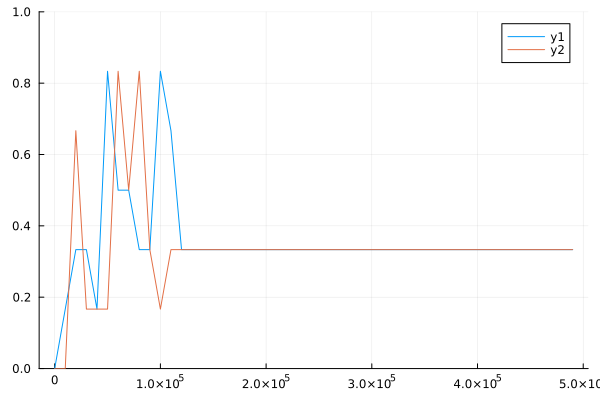

In [52]:
using Plots

x = 1:10_000:T
plot(x, [firm1.prices[x] firm2.prices[x]], ylim =(0, 1))

In [ ]:
plot(x, [profits[1][x] profits[2][x]], ylim =(0, 1))

### Multiple Runs

In [30]:
T = 500_000
runs = 50 #1000

convg_prices = Array{Tuple{Float64, Float64}}(undef,runs)
for i in 1:runs
    firm1, firm2 = duopoly(T, k = 6, α = 0.3, δ = 0.95)
    convg_prices[i] = (firm1.prices[end], firm2.prices[end])
end

In [31]:
freq = Dict()
for tup in convg_prices
    freq[tup] = get(freq, tup, 0) + 1
end

In [32]:
sorted = sort(freq, byvalue=true, rev=true)  # 500_000, 50 runs

OrderedCollections.OrderedDict{Any, Any} with 12 entries:
  (0.333333, 0.333333) => 24
  (0.5, 0.5)           => 10
  (0.5, 0.333333)      => 4
  (0.666667, 0.5)      => 2
  (0.666667, 0.666667) => 2
  (1.0, 0.5)           => 2
  (0.833333, 0.5)      => 1
  (0.166667, 0.833333) => 1
  (0.166667, 0.666667) => 1
  (0.333333, 0.166667) => 1
  (0.333333, 0.833333) => 1
  (0.5, 0.166667)      => 1